Checking the dataset, there are a lot of information about the client. However, some information is very redundant, not worth using them as single variables.
For example, 
- Flag mobile - flag email : Whether the client has provided his/her contact information
- Live region not work - Live city not work : whether contact address, permanent address, and work address are not matching to one another
- EXT source 1-3: Not explanable
- APT_AVE - Emergency state mode: information about the building the client lives
- social circle: information about the clients social circle
- provide docs 2-21: whether the client provided necessary documents
- AMT REQ credit bureau hr/day/week, etc.: Number of enquiries to Credit Bureau about the client one hour before application

However, there are some information (e.g., gender, age, ownership of car, home, etc.) that may critically deliver implication about the selection of the client.
Thus, we plan to build both models for prediction as well as models for drawing implication for strategies.


<h2> Meanigful Variables </h2>

- Gender "CODE\_GENDER"
- Family status "NAME\_FAMILY\_STATUS"
- Number of children "CNT\_CHILDREN"
- Number of family members "CNT\_FAM\_MEMBERS"

- Age "DAYS\_BIRTH"
- Employment period "DAYS\_EMPLOYED"
- Occupation type "OCCUPATION\_TYPE"
- Work organization type "ORGANIZATION\_TYPE"

- Education type "NAME\_EDUCATION\_TYPE"

- Total income "AMT\_INCOME\_TOTAL"
- Car ownership "FLAG\_OWN\_CAR"
- Real estate ownership "FLAG\_OWN\_REALTY"
- Income type "NAME\_INCOME\_TYPE"
- Housing type "NAME\_HOUSING\_TYPE"

- Credit amount "AMT\_CREDIT"
- Goods price "AMT\_ANNUITY"


In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [2]:
# Import necessary packages
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer

from sklearn.metrics import make_scorer, f1_score

pd.set_option('display.max_rows', 150)


# 1. Importing the data sets for training & test

In [3]:
import polars as pl
application_test = pl.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
application_train = pl.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')

<h3>Importing in Pandas form</h3>

In [4]:
app_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

## 1-1. Feature Selection

- Dropping variables:
    - 1) Region popularity / ratings
    - 2) Credit registration
    - 3) Contact information provided
    - 4) Address matched
    - 5) Building information
    - 6) Other registration miscellaneous details

In [5]:
# Dropping Region popularity & credit registration information
columns_drop_region = ["REGION_POPULATION_RELATIVE","DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
app_train_region_dropped = app_train.drop(columns = columns_drop_region, axis=1)
print("Dimension after dropping regions",app_train_region_dropped.shape)

# Dropping Contact information provided
train_drp_contact = app_train_region_dropped.drop(app_train_region_dropped.loc[:, 'FLAG_MOBIL':'FLAG_EMAIL'].columns, axis=1)
print("Dimension after dropping contact info",train_drp_contact.shape)

# Dropping region ratings / matching addresses
train_drp_address = train_drp_contact.drop(train_drp_contact.loc[:, 'REGION_RATING_CLIENT':'LIVE_CITY_NOT_WORK_CITY'].columns, axis=1)
print("Dimension after dropping address",train_drp_address.shape)

# Dropping EXT_SOURCE_1 & building info
train_drp_building = train_drp_address.drop(train_drp_address.loc[:, 'EXT_SOURCE_1':'AMT_REQ_CREDIT_BUREAU_YEAR'].columns, axis=1)
print("Dimension after dropping building",train_drp_building.shape)


Dimension after dropping regions (307511, 119)
Dimension after dropping contact info (307511, 113)
Dimension after dropping address (307511, 103)
Dimension after dropping building (307511, 22)


### Dropping Fairness variables

In [8]:
# Dropping Fairness values
columns_drop_fairness = ["CODE_GENDER","NAME_FAMILY_STATUS", "DAYS_BIRTH"]
train_drp_fair = train_drp_building.drop(columns = columns_drop_fairness, axis=1)
print("Dimension after dropping fairness variables",train_drp_fair.shape)

Dimension after dropping fairness variables (307511, 19)


In [6]:
train_drp_building.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,NaN,Laborers,1.0,Business Entity Type 3
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,-16765,-1188,NaN,Core staff,2.0,School
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,26.0,Laborers,1.0,Government
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,-19005,-3039,NaN,Laborers,2.0,Business Entity Type 3
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-19932,-3038,NaN,Core staff,1.0,Religion


## 1-2. Data Cleaning

### 1-2-1. Getting the subset

- Since the data size is too big observations (N=307,511), thus we have decided to reduce the sample size: 10% of the entire data set.

In [12]:
# Sample 10%
df_sample = train_drp_building.sample(frac=0.10, random_state=42)
print("Dimension of sample data", df_sample.shape)

Dimension of sample data (30751, 22)


In [13]:
df_sample.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE
245895,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,418500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,-13297,-762,19.0,Sales staff,4.0,Business Entity Type 3
98194,214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,1179000.0,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,-14778,-1141,11.0,Managers,1.0,Business Entity Type 3
36463,142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,495000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,-17907,-639,4.0,Sales staff,2.0,Self-employed
249923,389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,225000.0,Unaccompanied,State servant,Secondary / secondary special,Widow,House / apartment,-19626,-6982,NaN,High skill tech staff,1.0,Business Entity Type 3
158389,283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,234000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-20327,-1105,NaN,Laborers,1.0,Business Entity Type 3


### 1-2-2. Missing value treatment
### 1-2-3. Categorical value treatment

In [14]:
# Impute missing values for numerical columns with the median
num_imputer = SimpleImputer(strategy="median")
df_sample.loc[:,df_sample.dtypes != 'object'] = num_imputer.fit_transform(df_sample.loc[:, df_sample.dtypes != 'object'])

# Impute missing values for categorial columns with the string 'missing'
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df_sample.loc[:, df_sample.dtypes == 'object'] = cat_imputer.fit_transform(df_sample.loc[:, df_sample.dtypes == 'object'])

# One-hot encode the categorical variables
df_sample_encoded = pd.get_dummies(df_sample, drop_first=True)

print("Dimensions after the treatment", df_sample_encoded.shape)

Dimensions after the treatment (30751, 118)


In [15]:
# Convert all True/False to 1/0 in the entire DataFrame
df_sample_encoded = df_sample_encoded.astype(int)

# Display the first few rows to verify changes
df_sample_encoded.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_missing,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,...,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
245895,384575,0,2,207000,465457,52641,418500,-13297,-762,19,4,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98194,214010,0,0,247500,1281712,48946,1179000,-14778,-1141,11,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36463,142232,0,0,202500,495000,39109,495000,-17907,-639,4,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249923,389171,0,0,247500,254700,24939,225000,-19626,-6982,9,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
158389,283617,0,0,112500,308133,15862,234000,-20327,-1105,9,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Fairness data set processing



In [9]:
# Sample 10%
df_sample_fair = train_drp_fair.sample(frac=0.10, random_state=42)
print("Dimension of sample fairness data", df_sample_fair.shape)

# Impute missing values for numerical columns with the median
num_imputer = SimpleImputer(strategy="median")
df_sample_fair.loc[:,df_sample_fair.dtypes != 'object'] = num_imputer.fit_transform(df_sample_fair.loc[:, df_sample_fair.dtypes != 'object'])

# Impute missing values for categorial columns with the string 'missing'
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df_sample_fair.loc[:, df_sample_fair.dtypes == 'object'] = cat_imputer.fit_transform(df_sample_fair.loc[:, df_sample_fair.dtypes == 'object'])

# One-hot encode the categorical variables
df_sample_fair_encoded = pd.get_dummies(df_sample_fair, drop_first=True)

print("Fairness Dimensions after the treatment", df_sample_fair_encoded.shape)

# Convert all True/False to 1/0 in the entire DataFrame
df_sample_fair_encoded = df_sample_fair_encoded.astype(int)

# Display the first few rows to verify changes
df_sample_fair_encoded.head()

Dimension of sample fairness data (30751, 19)
Fairness Dimensions after the treatment (30751, 110)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_missing,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,...,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
245895,384575,0,2,207000,465457,52641,418500,-762,19,4,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98194,214010,0,0,247500,1281712,48946,1179000,-1141,11,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36463,142232,0,0,202500,495000,39109,495000,-639,4,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249923,389171,0,0,247500,254700,24939,225000,-6982,9,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
158389,283617,0,0,112500,308133,15862,234000,-1105,9,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,

# 2. EDA

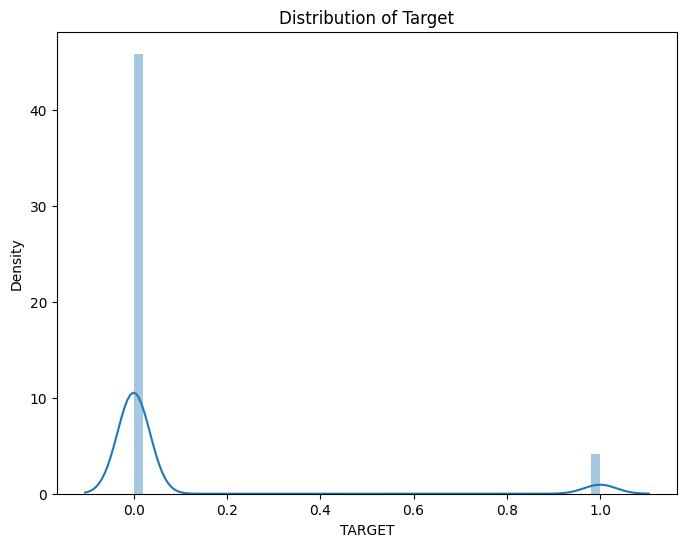

In [16]:
plt.figure(figsize=(8,6))
plt.title("Distribution of Target")
ax = sns.distplot(df_sample_encoded["TARGET"])

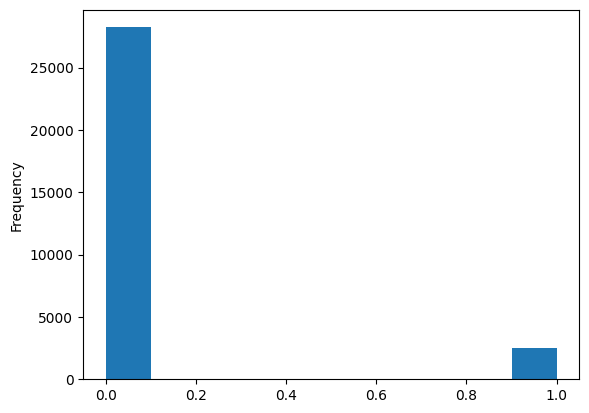

In [17]:
df_sample_encoded['TARGET'].astype(int).plot.hist();

### 2-2. Gender distribution

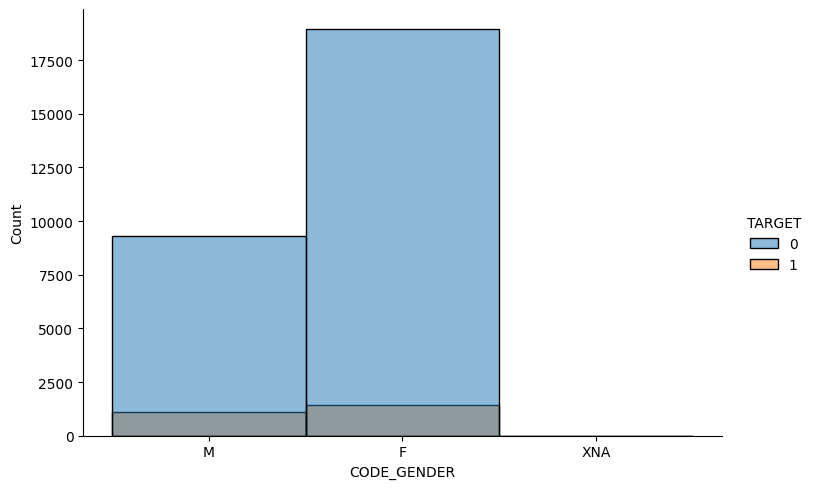

In [18]:
sns.displot(
data = df_sample,
x = "CODE_GENDER",
hue = "TARGET",
alpha = 0.5, aspect=1.5)

### 2-3. Age

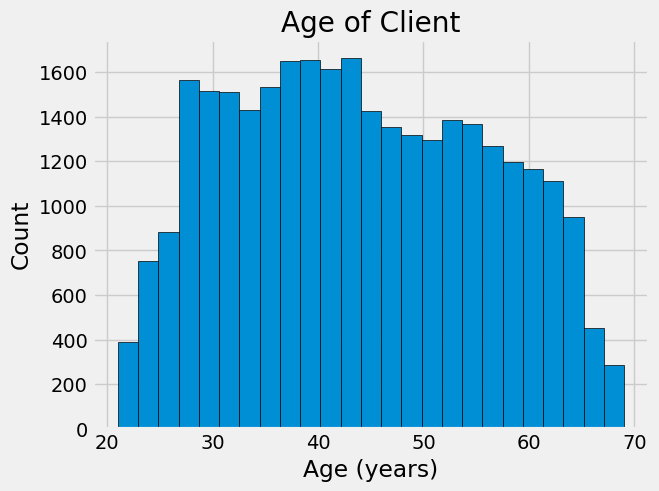

In [19]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(-df_sample['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

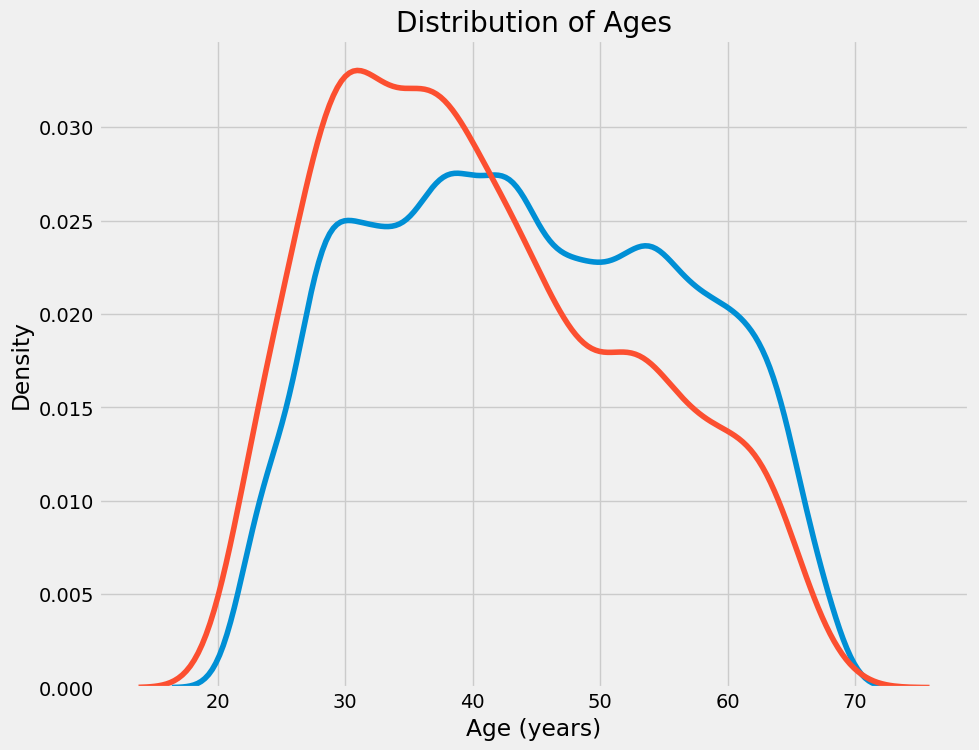

In [20]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(-df_sample.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(-df_sample.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [21]:
# Age information into a separate dataframe
age_data = df_sample[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = -age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
245895,0,-13297,36.430137,"(35.0, 40.0]"
98194,0,-14778,40.487671,"(40.0, 45.0]"
36463,0,-17907,49.060274,"(45.0, 50.0]"
249923,0,-19626,53.769863,"(50.0, 55.0]"
158389,0,-20327,55.690411,"(55.0, 60.0]"
226343,0,-19130,52.410959,"(50.0, 55.0]"
69571,0,-15722,43.073973,"(40.0, 45.0]"
181469,0,-10801,29.591781,"(25.0, 30.0]"
114736,0,-23516,64.427397,"(60.0, 65.0]"
114007,0,-8755,23.986301,"(20.0, 25.0]"


In [22]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.130506,-8540.134584,23.397629
"(25.0, 30.0]",0.107303,-10151.863487,27.813325
"(30.0, 35.0]",0.104043,-11843.546485,32.448073
"(35.0, 40.0]",0.099197,-13694.250590,37.518495
"(40.0, 45.0]",0.078903,-15503.828605,42.476243
"(45.0, 50.0]",0.066246,-17333.309722,47.488520
"(50.0, 55.0]",0.064246,-19193.748324,52.585612
"(55.0, 60.0]",0.057152,-20980.570572,57.481015
"(60.0, 65.0]",0.061900,-22778.133049,62.405844


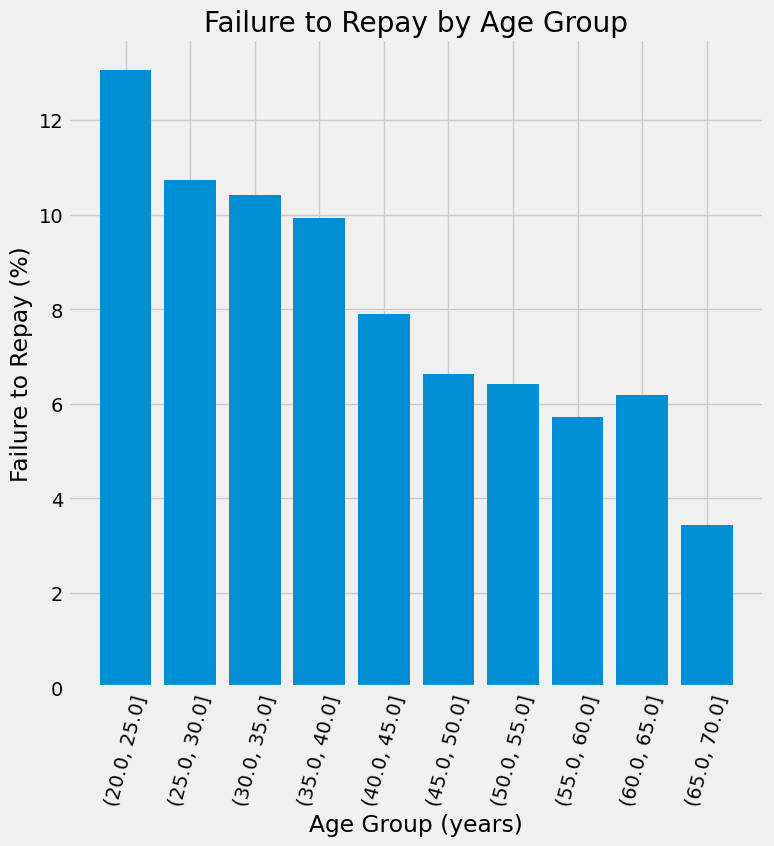

In [23]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### 2-4. Employment

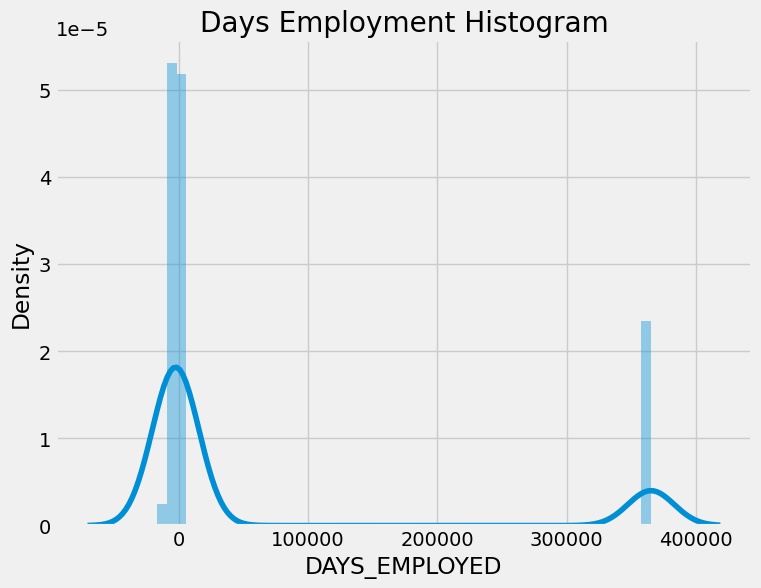

In [24]:
plt.figure(figsize=(8,6))
plt.title("Days Employment Histogram")
ax = sns.distplot(df_sample["DAYS_EMPLOYED"])

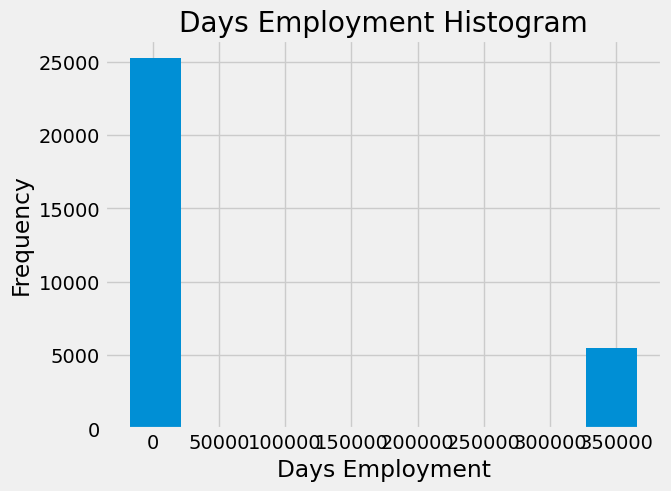

In [25]:
df_sample['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

# 3. Prediction Model Analysis

## 3-1. Split train & test data sets

In [26]:
# Define features & target variable
# df_sample_encoded
X = df_sample_encoded.drop("TARGET", axis=1)
y = df_sample_encoded["TARGET"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (24600, 117)
X_test:  (6151, 117)
y_train:  (24600,)
y_test:  (6151,)


### Fairness data split train & test

In [10]:
# Define features & target variable
# df_sample_encoded
X_fair = df_sample_fair_encoded.drop("TARGET", axis=1)
y_fair = df_sample_fair_encoded["TARGET"]

# Split the data into training and testing sets
X_train_fair, X_test_fair, y_train_fair, y_test_fair = train_test_split(X_fair, y_fair, test_size=0.2, random_state=42)

## 3-2. Logistic Regression

In [28]:
# Initialize logistic regression model:
logistic_model = LogisticRegression(max_iter=1000) # increased max_iter for convergence

# Set up K-Fold cross-validation
k_fold = KFold(n_splits=5, random_state=None, shuffle=False)

# Perform k-fold CV for accuracy
logit_score_accuracy = cross_val_score(logistic_model, X_train, y_train, cv=k_fold, scoring="accuracy")

# Perform k-fold CV for F1 score:
logit_f1 = make_scorer(f1_score, average="binary")
logit_f1_sc = cross_val_score(logistic_model, X_train, y_train, cv=k_fold, scoring=logit_f1)

# Output the accuracy and F1 score for each fold
print("Logistic Accuracy for each fold:", logit_score_accuracy)
print("Logistic Average Accuracy: {:.2f}%".format(np.mean(logit_score_accuracy)*100))
print("Logistic Standard Deviation (Accuracy): {:.2f}%".format(np.std(logit_score_accuracy)*100))


Logistic Accuracy for each fold: [0.91686992 0.92154472 0.91199187 0.91747967 0.92154472]
Logistic Average Accuracy: 91.79%
Logistic Standard Deviation (Accuracy): 0.35%


### Logistic Fairness

In [29]:
# Initialize logistic regression model:
logistic_model = LogisticRegression(max_iter=1000) # increased max_iter for convergence

# Set up K-Fold cross-validation
k_fold = KFold(n_splits=5, random_state=None, shuffle=False)

# Perform k-fold CV for accuracy
fair_logit_score_accuracy = cross_val_score(logistic_model, X_train_fair, y_train_fair, cv=k_fold, scoring="accuracy")

# Perform k-fold CV for F1 score:
# logit_f1 = make_scorer(f1_score, average="binary")
# logit_f1_sc = cross_val_score(logistic_model, X_train, y_train, cv=k_fold, scoring=logit_f1)

# Output the accuracy and F1 score for each fold
print("Logistic Accuracy for each fold:", fair_logit_score_accuracy)
print("Logistic Average Accuracy: {:.2f}%".format(np.mean(fair_logit_score_accuracy)*100))
print("Logistic Standard Deviation (Accuracy): {:.2f}%".format(np.std(fair_logit_score_accuracy)*100))


Logistic Accuracy for each fold: [0.91686992 0.92154472 0.91199187 0.91747967 0.92154472]
Logistic Average Accuracy: 91.79%
Logistic Standard Deviation (Accuracy): 0.35%


### 3-2-1. Logistic Coefficients & P-value

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Initialize and train the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)  # Fit the model

# Now, the logistic_model object should have the coef_ attribute
coefficients = logistic_model.coef_[0]  # Get the coefficients

# Add a constant to the features for the statsmodels logistic regression
X_train_with_const = sm.add_constant(X_train)

# Fit the logistic regression model using statsmodels to get the p-values
logit_model_sm = sm.Logit(y_train, X_train_with_const).fit(disp=0)

# Get the summary of the model
summary = logit_model_sm.summary2().tables[1]

# Create a DataFrame to display coefficients and p-values
results_df = pd.DataFrame({
    'Variable': summary.index,
    'Coefficient': summary['Coef.'],
    'P-value': summary['P>|z|']
})

results_df.reset_index(drop=True, inplace=True)
results_df


## 3-3. LDA (Linear Discriminant Analysis)

In [ ]:
# Initializing the LDA model
lda_model = LDA()

# Set up k-fold cross-validation
k_fold = KFold(n_splits = 5, random_state=None, shuffle=False)

# Perform k-fold cross-validation and store the scores
lda_scores = cross_val_score(lda_model, X_train, y_train, cv=k_fold, scoring='accuracy')

# Output the accuracy for each fold:
print(lda_scores)
print("Average Accuracy: {:.2f}%".format(np.mean(lda_scores)*100))
print("Standard Deviation: {:.2f}%".format(np.std(lda_scores)*100))

## 3-4. QDA (Quadratic Discriminant Analysis)

In [ ]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Initialize the QDA model:
qda_model = QDA()

# Set up k-fold cross-validation
k_fold = KFold(n_splits=5, random_state=None, shuffle=False)

# Perform k-fold CV and store the scores
qda_scores = cross_val_score(qda_model, X_train, y_train, cv=k_fold, scoring='accuracy')

# Output for QDA results
print(qda_scores)
print("Average Accuracy: {:.2f}%".format(np.mean(qda_scores)*100))
print("Standard Deviation: {:.2f}%".format(np.std(qda_scores)*100))

## 3-5. SVM (Support Vector Machine)

<h3> Due to heavy computation complexity, we have decided to reduce the training data set size for SVM models </h3>

In [ ]:
# Sample 10%
X_train_svm = X_train.sample(frac=0.05, random_state=42)
y_train_svm = y_train.sample(frac=0.05, random_state=42)

print("Dimension of sample data (X_train_svm)", X_train_svm.shape)
print("Dimension of sample data (y_train_svm)", y_train_svm.shape)

In [ ]:
# # from sklearn.svm import SVC
# # # Set up k-fold CV
# k_fold = KFold(n_splits=5, random_state=None, shuffle=False)

# # # Initialize SVM models with different kernels:
# svm_linear = SVC(kernel='linear')
# svm_poly = SVC(kernel='poly')
# svm_rbf = SVC(kernel='rbf')
# svm_sigmoid = SVC(kernel='sigmoid')

# # # Perform CV and store scores
# kernel_linear = cross_val_score(svm_linear, X_train_svm, y_train_svm, cv=k_fold, scoring='accuracy')
# kernel_poly = cross_val_score(svm_poly, X_train_svm, y_train_svm, cv=k_fold, scoring='accuracy')
# kernel_rbf = cross_val_score(svm_rbf, X_train_svm, y_train_svm, cv=k_fold, scoring='accuracy')
# kernel_sigmoid = cross_val_score(svm_sigmoid, X_train_svm, y_train_svm, cv=k_fold, scoring='accuracy')

## 3-6. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Initialize Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up K-Fold cross-validation
k_fold = KFold(n_splits=5, random_state=42, shuffle=True)

# Perform k-fold CV for accuracy
forest_score_accuracy = cross_val_score(random_forest_model, X_train, y_train, cv=k_fold, scoring="accuracy")

# Perform k-fold CV for F1 score
forest_f1 = make_scorer(f1_score, average="binary")
forest_f1_sc = cross_val_score(random_forest_model, X_train, y_train, cv=k_fold, scoring=forest_f1)

# Output the accuracy and F1 score for each fold
print("Random Forest Accuracy for each fold:", forest_score_accuracy)
print("Random Forest Average Accuracy: {:.2f}%".format(np.mean(forest_score_accuracy)*100))
print("Random Forest Standard Deviation (Accuracy): {:.2f}%".format(np.std(forest_score_accuracy)*100))
print("Random Forest F1 Score for each fold:", forest_f1_sc)
print("Random Forest Average F1 Score: {:.2f}".format(np.mean(forest_f1_sc)))


### 3-6-1. Random Forest Importance Score

In [ ]:
# Fit a random forest classifier and extract feature importances (this is a placeholder code)
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_

# For demonstration purposes, let's create a dummy 'importances' array
importances = np.random.rand(X_train.shape[1])  # Assuming X_train has been defined

# Create a DataFrame of features and their importance scores
feature_importance_scores = pd.DataFrame({
    'Feature': X_train.columns,  # Assuming X_train has named columns
    'Importance': importances
})

# Sort by importance
feature_importance_scores = feature_importance_scores.sort_values(by='Importance', ascending=False)

# Now we can visualize the top 10 features
# Select the top 10 features
top_features = feature_importance_scores.head(10)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest importance at the top
plt.show()


## 3-7. Saving the performance results

In [ ]:
import matplotlib.pyplot as plt

# Data from the provided table
models = ['Logistic Regression', 'LDA', 'QDA', 'Random Forest']
accuracy_scores = [91.79, 91.77, 75.23, 91.79]
std_devs = [0.35, 0.34, 32.61, 0.14]

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar graph for accuracy scores
ax1.bar(models, accuracy_scores, color='skyblue', alpha=0.6, label='Accuracy Score')
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy Score (%)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# Line graph for standard deviation
ax2.plot(models, std_devs, color='crimson', marker='o', label='Standard Deviation')
ax2.set_ylabel('Standard Deviation (%)', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

# Title and custom x-axis tick labels
fig.suptitle('Model Performance Comparison')
ax1.set_xticklabels(models, rotation=45)

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


# 4. Appendix

### Feature Histogram Overview

In [ ]:
numeric_df = df_sample.select_dtypes(include=np.number)

In [ ]:
numeric_df.drop(columns=['SK_ID_CURR'], inplace=True)

In [ ]:
numeric_df

In [ ]:
fig = plt.figure(figsize=[20,70])
for i, col in enumerate(numeric_df.columns):
    ax = plt.subplot(21,5,i+1)
    ax.hist(numeric_df[col])
    ax.set_title(col)

fig.suptitle('Feature Histograms', fontsize=25)
fig.tight_layout()
plt.show()

### Feature Histograms for Categorical Data

In [ ]:
categorical_df = df_sample.select_dtypes(exclude=np.number)
categorical_df

In [ ]:
categorical_df.fillna('NA', inplace=True)

In [ ]:
fig = plt.figure(figsize=[20,20])
for i, col in enumerate(categorical_df.columns):
    ax = plt.subplot(4,5,i+1)
    ax.hist(categorical_df[col])
    ax.set_title(col)
    for tick in ax.get_xticklabels():
        tick.set_rotation(75)

fig.suptitle('Feature Histograms', fontsize=25)
fig.tight_layout()
plt.show()

## 4-2. Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# one-hot encoding of categorical values into numerical values
encoded_df = pd.get_dummies(df_sample)
X_train = encoded_df.drop(columns=['SK_ID_CURR','TARGET'])
X_train.dropna(axis=1, inplace=True)
y_train = encoded_df['TARGET']

# data normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)

In [ ]:
X_train.shape

In [ ]:
n_features = X_train.shape[1]
pca = PCA(n_components=n_features)
pca.fit(X_train)

In [ ]:
# plot
plt.plot(np.arange(1,n_features+1), pca.explained_variance_ratio_,'k.-', label='Individual')
plt.plot(np.arange(1,n_features+1), np.cumsum(pca.explained_variance_ratio_),'b.-', label='Cumulative')
plt.legend()
plt.xlabel('Component Number')
plt.ylabel('Portion of Variance Explained')
plt.title('Variance Explained vs Number of Components')
plt.show()

In [ ]:
# plot
plt.plot(np.arange(1,21), pca.explained_variance_ratio_[:20],'k.-', label='Individual')
plt.plot(np.arange(1,21), np.cumsum(pca.explained_variance_ratio_)[:20],'b.-', label='Cumulative')
plt.legend()
plt.xlabel('Component Number')
plt.ylabel('Portion of Variance Explained')
plt.title('Variance Explained vs Number of Components')
plt.show()

### PCA on Normalized Data

In [ ]:
n_features = X_train_normalized.shape[1]
pca = PCA(n_components=n_features)
pca.fit(X_train_normalized)

In [ ]:
# plot
plt.plot(np.arange(1,n_features+1), pca.explained_variance_ratio_,'k.-', label='Individual')
plt.plot(np.arange(1,n_features+1), np.cumsum(pca.explained_variance_ratio_),'b.-', label='Cumulative')
plt.legend()
plt.xlabel('Component Number')
plt.ylabel('Portion of Variance Explained')
plt.title('Variance Explained vs Number of Components')
plt.show()